In [1]:
# Librerías utilizadas por el script
import timm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import torch

from sklearn.metrics import classification_report
from fastai.vision.all import *

"""
!pip install -Uqq fastbook
!pip install nbdev
"""
import fastbook

fastbook.setup_book()
import fastai
import fastcore

print(f'fastcore version {fastcore.__version__} installed')
print(f'fastai version {fastai.__version__} installed')
from nbdev.showdoc import *
from fastai.vision.all import *

fastcore version 1.5.29 installed
fastai version 2.7.14 installed


In [2]:
torch.cuda.is_available()

True

A continuación, se declaran las constantes usadas como parámetros a las funciones

In [3]:
# Número de clases. 2 para la binaria.
NUM_CLASSES = 2
TRAIN_DIR = "trainThumbnails/"
VALID_PCT = 0.3
SEED = 19
# Número de canales de cada imagen
CHANNELS = 3
IMAGE_RESIZE = 386
RESIZE_METHOD = 'squish'
LOSS_FUNC = CrossEntropyLossFlat()
METRICS = [accuracy, BalancedAccuracy(), error_rate, Recall(), Precision()]

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 0
EARLY_STOP_PATIENCE = 3

BATCH_SIZE = 32

In [4]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''


def readIm(filename, flagColor=1):
    # cv2 reads BGR format
    im = cv2.imread(filename)
    # change to  RGB and return the image
    if (flagColor):
        return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    # change from BGR to grayscale instead if flag is 0
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''


def rangeDisplay01(im, flag_GLOBAL=True):
    im = im.astype(float)
    if flag_GLOBAL:
        im = (im - im.min()) / (im.max() - im.min())
    else:
        # bands normalization
        for band in range(im.shape[2]):
            im[:, :, band] = (im[:, :, band] - im[:, :, band].min()) / (im[:, :, band].max() - im[:, :, band].min())
            # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
    return im


'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''


def displayIm(im, title='Result', factor=2):
    # First normalize range
    max = np.max(im)
    min = np.min(im)
    if min < 0 or max > 255:
        im = rangeDisplay01(im, flag_GLOBAL=True)
    if len(im.shape) == 3:
        # im es tribanda
        plt.imshow(im, cmap='jet')
    else:
        # im es monobanda
        plt.imshow(im, cmap='gray')
    figure_size = plt.gcf().get_size_inches()
    plt.gcf().set_size_inches(factor * figure_size)
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # eliminamos numeración
    plt.show()


# This function display the KeyPoints of an image
def showKP(im, kp, title):
    im_orig = im.copy()
    for curKey in kp:
        x = np.int(curKey.pt[0])
        y = np.int(curKey.pt[1])
        size = np.int(curKey.size)
        cv2.circle(im, (x, y), 40, color=(255, 0, 0), thickness=4)
    displayIm(im, title)

Leemos el dataframe con la información asoaciada a las etiquetas y otros metadatos

In [10]:
train_df = pd.read_csv('pruebas.csv')
display(train_df)

,Unnamed: 0,image,dir,label,dataset,bin
0,0,ASAN_8196.png,datasets/Asan/dataset/hemangioma/ASAN_8196.png,hemangioma,ASAN,Benign
1,1,ASAN_10059.png,datasets/Asan/dataset/dermatofibroma/ASAN_10059.png,dermatofibroma,ASAN,Benign
2,2,SEV_248_74.png,datasets/Severance/thumbnails/SEV_248_74.png,pyogenic_granuloma,SEVERANCE,Benign
3,3,ISIC_0068761.JPG,datasets/ISIC/Melanoma/ISIC_0068761.JPG,melanoma,ISIC,Malignant
4,4,SEV_062_17.png,datasets/Severance/thumbnails/SEV_062_17.png,squamous_cell_carcinoma,SEVERANCE,Malignant
...,...,...,...,...,...,...
64876,64876,ISIC_0014898.JPG,datasets/ISIC/Nevus/ISIC_0014898.JPG,nevus,ISIC,Benign
64877,64877,SEV_345_42.png,datasets/Severance/thumbnails/SEV_345_42.png,syringoma,SEVERANCE,Benign
64878,64878,ISIC_0062505.JPG,datasets/ISIC/Melanoma/ISIC_0062505.JPG,melanoma,ISIC,Malignant
64879,64879,SEV_164_8.png,datasets/Severance/thumbnails/SEV_164_8.png,hemangioma,SEVERANCE,Benign


In [6]:
import os
import numpy as np
from concurrent.futures import ThreadPoolExecutor
from PIL import Image
import cv2

# Directorio donde se encuentran las imágenes
directorio_imagenes = "trainThumbnails"
"""
# Función para procesar una imagen y calcular los valores de brillo
def procesar_imagen(filename):
    ruta_completa = os.path.join(directorio_imagenes, filename)
    imagen = readIm(ruta_completa)
    # Calcula el brillo promedio de la imagen
    mean = [np.mean(imagen[:,:,0]), np.mean(imagen[:,:,1]), np.mean(imagen[:,:,2])]
    std = [np.std(imagen[:,:,0]), np.std(imagen[:,:,1]), np.std(imagen[:,:,2])]
    return mean, std

# Recorre todas las imágenes en el directorio de manera paralela
with ThreadPoolExecutor() as executor:
    futures = []
    for filename in os.listdir(directorio_imagenes):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            futures.append(executor.submit(procesar_imagen, filename))

# Obtiene los resultados
mean_values = []
std_values = []
for future in futures:
    mean, std = future.result()
    mean_values.append(mean)
    std_values.append(std)

# Calcula la media y la desviación estándar de los valores de brillo
med_col = np.mean(mean_values, axis=0)
desv_col = np.std(std_values, axis=0)

print("Valores de brillo promedio:", med_col)
print("Desviación estándar de los valores de brillo:", desv_col)
"""

'\n# Función para procesar una imagen y calcular los valores de brillo\ndef procesar_imagen(filename):\n    ruta_completa = os.path.join(directorio_imagenes, filename)\n    imagen = readIm(ruta_completa)\n    # Calcula el brillo promedio de la imagen\n    mean = [np.mean(imagen[:,:,0]), np.mean(imagen[:,:,1]), np.mean(imagen[:,:,2])]\n    std = [np.std(imagen[:,:,0]), np.std(imagen[:,:,1]), np.std(imagen[:,:,2])]\n    return mean, std\n\n# Recorre todas las imágenes en el directorio de manera paralela\nwith ThreadPoolExecutor() as executor:\n    futures = []\n    for filename in os.listdir(directorio_imagenes):\n        if filename.lower().endswith((\'.jpg\', \'.jpeg\', \'.png\')):\n            futures.append(executor.submit(procesar_imagen, filename))\n\n# Obtiene los resultados\nmean_values = []\nstd_values = []\nfor future in futures:\n    mean, std = future.result()\n    mean_values.append(mean)\n    std_values.append(std)\n\n# Calcula la media y la desviación estándar de los valor

Creamos el dataset. Para ello, me ayudaré de fastai y crearé un conjunto de imágenes que se usarán para train y test. Nota: hay dos columnas de etiquetas, por lo que se han hecho dos funciones distintas; una que se ocupa de las etiquetas binarias, y otra de las subcategorías. Comenzaremos primero por clasificación binaria.

In [11]:
def binary_label(fname):
    global train_df
    el = train_df.loc[train_df['image'] == str(fname).split("/")[1]]
    return el['bin'].values[0]


def multi_label(fname):
    global train_df
    el = train_df.loc[train_df['image'] == str(fname)]
    return ((el['label'].values[0]))

In [12]:
trainSet = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # La entrada es un bloque de imagenes, y la salida, categorias
    get_items=get_image_files,  # Utilizamos el mñetodo get_image_files proporcionado en el Notebook
    splitter=RandomSplitter(valid_pct=VALID_PCT, seed=SEED),  # Establecida semilla 0
    get_y=binary_label,  # Las etiquetas son especificadas como contenido del dataset en si
    item_tfms=[Resize(IMAGE_RESIZE, method=RESIZE_METHOD)],  # Redimensionado
    batch_tfms=Normalize.from_stats(*imagenet_stats)
).dataloaders(TRAIN_DIR, bs=BATCH_SIZE)

In [13]:
resnet50 = vision_learner(trainSet, 'resnet50', loss_func=LOSS_FUNC, metrics=METRICS,
                          pretrained=True)
print(resnet50.summary())

Sequential (Input shape: 32 x 3 x 386 x 386)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 193 x 193 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 97 x 97   
MaxPool2d                                                      
Conv2d                                    4096       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

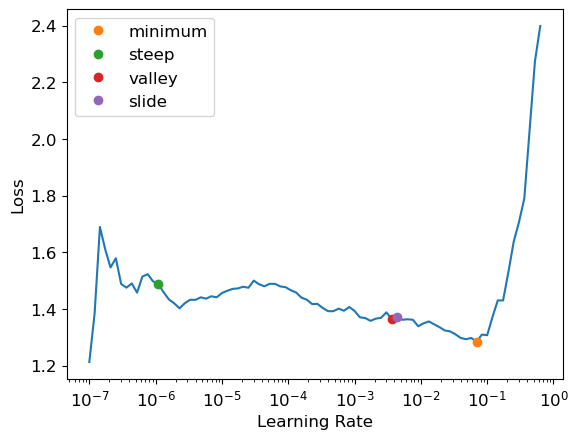

In [10]:
lrs = resnet50.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [11]:
print(trainSet.vocab)

['Benign', 'Malignant']


In [12]:
early_stopping = EarlyStoppingCallback(monitor='valid_loss', patience=EARLY_STOP_PATIENCE)
save_callback = SaveModelCallback(monitor='valid_loss', fname='best_model')

resnet50.fine_tune(NUM_EPOCHS, lrs[2],
                   cbs=[early_stopping, save_callback])


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time


epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,error_rate,recall_score,precision_score,time
0,0.461678,0.421927,0.805282,0.601559,0.194718,0.242518,0.629470,07:26


In [13]:
resnet50.summary()

Sequential (Input shape: 32 x 3 x 386 x 386)
Layer (type)         Output Shape         Param #    Trainable 
                     32 x 64 x 193 x 193 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     32 x 64 x 97 x 97   
MaxPool2d                                                      
Conv2d                                    4096       True      
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      True      
BatchNorm2d                               128        True      
Identity                                                       
ReLU                                                           
Identity                  

In [14]:
state = torch.load('models/best_model.pth')
preds, targets = resnet50.get_preds(ds_idx=1)  # ds_idx=1 para el conjunto de validación


In [15]:
y_true = targets.numpy()
y_pred = preds.argmax(dim=1).numpy()  # Convierte las probabilidades en etiquetas predichas

In [16]:
print(classification_report(y_true, y_pred,target_names=trainSet.vocab))

              precision    recall  f1-score   support

      Benign       0.82      0.96      0.89     15254
   Malignant       0.63      0.24      0.35      4210

    accuracy                           0.81     19464
   macro avg       0.73      0.60      0.62     19464
weighted avg       0.78      0.81      0.77     19464



In [17]:
torch.save(resnet50,'modeloentero.pth')

## ONNX

Convertimos al formato estándar

In [38]:
resnet50.export()
resnet50.path

Path('.')

In [53]:
testmodel = torch.load('export.pkl')
model_dict = testmodel.state_dict()
torch.save(model_dict, 'miModelo.pth')

In [67]:
loaded_model = models.resnet50
loaded_model = vision_learner(trainSet, 'resnet50', loss_func=LOSS_FUNC, metrics=METRICS) # Crea un modelo vacío con la misma arquitectura
loaded_model.load_state_dict(torch.load('miModelo.pth'))

<All keys matched successfully>

In [57]:
type(loaded_model)

fastai.learner.Learner

In [72]:
class InferenceWrapper(nn.Module):
    def __init__(self, model, normalize_mean, normalize_std, scale_inp=False, channels_last=False):
        super().__init__()
        self.model = model
        self.register_buffer("normalize_mean", normalize_mean)
        self.register_buffer("normalize_std", normalize_std)
        self.scale_inp = scale_inp
        self.channels_last = channels_last
        self.softmax = nn.Softmax(dim=1)

    def preprocess_input(self, x):
        if self.scale_inp:
            x = x / 255.0

        if self.channels_last:
            x = x.permute(0, 3, 1, 2)

        x = (x - self.normalize_mean) / self.normalize_std
        return x

    def forward(self, x):
        x = self.preprocess_input(x)
        x = self.model(x)
        x = self.softmax(x)
        return x

In [76]:
# Define the normalization mean and standard deviation
mean_tensor = torch.tensor(imagenet_stats[0]).view(1, 3, 1, 1)
std_tensor = torch.tensor(imagenet_stats[1]).view(1, 3, 1, 1)

# Set the model to evaluation mode
resnet50.eval()

# Wrap the model with preprocessing and post-processing steps
wrapped_model = InferenceWrapper(model,
                                 mean_tensor,
                                 std_tensor,
                                 scale_inp=False, # Scale input values from the rang [0,255] to [0,1]
                                 channels_last=False, # Have the model expect input in channels-last format
                                 )

In [16]:
resnet50.load('best_model')

/home/cristhian/anaconda3/lib/python3.11/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


In [17]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = resnet50.model.eval() # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1) # define softmax
normalization_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization layer

# assembling the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

In [22]:
torch.onnx.export(
    final_model,
    torch.randn(32, 3, 386, 386).to('cuda'),
    'model.onnx',
    do_constant_folding=True,
    export_params=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=17,
    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                  'output' : {0 : 'batch_size'}}
)

Inferimos en ONNX

In [23]:
from PIL import Image

def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size,size))

    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2,0,1).astype(np.float32)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model
    image /= 255
    image = image[None, ...]
    return image

In [30]:
import numpy as np
import onnxruntime as rt

labels = ['Benign', 'Malignant']

# get image as tensor - 1 x 3 x 256 x 256 dimensions
img = image_transform_onnx('trainThumbnails/ISIC_0068761.JPG', 386)

# initialize onnx runtime inference session
sess = rt.InferenceSession('model.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions (important for debugging)
input_dims = sess.get_inputs()[0].shape

print(f"Input layer name: {input_name}, Output layer name: {output_name}, Input Dimension: {input_dims}")

results = sess.run([output_name], {input_name: img})[0]
print(f"It's a {labels[np.argmax(results)]}", results)

Input layer name: input, Output layer name: output, Input Dimension: ['batch_size', 3, 386, 386]
It's a Malignant [[0.43654725 0.5634528 ]]
